## Lateral flow signal quantification

Compiled by Jacqueline A. Valeri and Miguel A. Alcantar

Last updated: December 31, 2019

This notebook describes the workflow for automation of lateral flow signal quantification. The final output is the ratio of the mean intensity of the sample- and contol-band.

Paper citation.

In [1]:
# importing packages required to sucessfully run the notebook

import cv2 # openCV -- contains several useful functions for image analysis and band identification
import skimage 
import numpy as np

import imutils
from imutils import contours 

import matplotlib.pyplot as plt
from ocr.helpers import implt, resize, ratio

print("OpenCV: " + cv2.__version__) 
print("Numpy: " + np.__version__)

plt.rcParams['figure.figsize'] = (9.0, 9.0)

OpenCV: 4.1.1
Numpy: 1.17.2


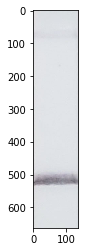

In [2]:
# read and plot original image
# image is expected to be in jpeg format because this is the starard format for android phones (and most mobile devices)

# read image using openCV
image_path = "images/CXCL9_NY346/191217_NY346_NEG_CTL.jpg"
image_orig = cv2.imread(image_path)

target_to_detect = "CMV" # target should be either 'CMV', ' BKV', or 'CXCL9'  

image_orig_copy = image_orig.copy() # making copy of the original image

# display image using python function
implt(image_orig)

# these functions will display the image in a different window.
# cv2.imshow("Original image", image_orig)
# cv2.waitKey(0)
# cv2.destroyAllWindows()



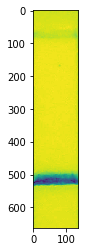

In [3]:
# convert image from BGR to RGB to 8-bit Grayscale
# image_RBG = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
# image_GRAY = cv2.cvtColor(image_RBG, cv2.COLOR_RGB2GRAY)
image_GRAY = cv2.cvtColor(image_orig, cv2.COLOR_BGR2GRAY)
implt(image_GRAY)

# cv2.imshow("Grayscale image", image_GRAY)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

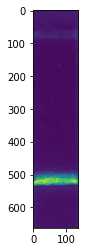

In [4]:
# invert image colors (i.e., obtain negative of the image)
image_invert = cv2.bitwise_not(image_GRAY)
implt(image_invert)

image_invert_orig = image_invert.copy() # saving original inverted image such that contour box is not saved over

# cv2.imshow("Inverted image", image_invert_jpg)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

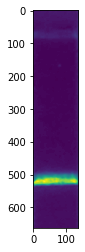

In [5]:
# apply Gaussian blur (helps with minimizing the effect of noisy artifactual bright-spots)
image_blur = cv2.GaussianBlur(image_invert, (11, 11), 0)

implt(image_blur)

# cv2.imshow("Gaussian blur image", image_blur_jpg)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

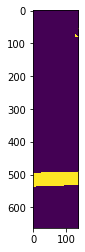

In [6]:
# apply threshold to binarize image
# threshold was chosen as mean + 0.6*sigma
thresh = float(cv2.meanStdDev(image_blur)[0]) + 0.6*float(cv2.meanStdDev(image_blur)[1])
image_thresh = cv2.threshold(image_blur, thresh, 255, cv2.THRESH_BINARY)[1]

implt(image_thresh)

# cv2.imshow("Threshold", image_thresh_jpg)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

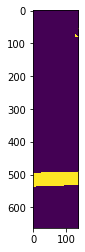

In [7]:
# noise reduction by eroding and dialating 
# resources for erosion and dialiation can be found at: 
# page 127 - 129 (http://szeliski.org/Book/drafts/SzeliskiBook_20100903_draft.pdf)
# https://docs.opencv.org/2.4/doc/tutorials/imgproc/erosion_dilatation/erosion_dilatation.html

image_erode = cv2.erode(image_thresh, None, iterations=1)
image_no_noise = cv2.dilate(image_erode, None, iterations=1)
implt(image_no_noise)

# cv2.imshow("No noise", image_no_noise_jpg)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

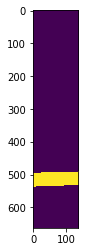

In [8]:
# perform a connected component analysis (CCA) on the thresholded image
# essentially, this helps identify the large-continuous blobs that correspond to sample and control bands

# the following tutorial was helpful for clearly explaining how to perform bright-spot detection using CCA: 
# https://www.pyimagesearch.com/2016/10/31/detecting-multiple-bright-spots-in-an-image-with-python-and-opencv/

labels = skimage.measure.label(image_no_noise, neighbors=8, background=0)
mask = np.zeros(image_no_noise.shape, dtype="uint8")
 
for label in np.unique(labels):
    if label == 0:
        continue

    labelMask = np.zeros(image_no_noise.shape, dtype="uint8")
    labelMask[labels == label] = 255
    numPixels = cv2.countNonZero(labelMask)
 
    # only add to mask if the identified sample and/or control band is sufficiently large 
    # sufficiently large here means that the band contains at the very least 3*image_width number of pixels 
    if numPixels > mask.shape[1]*3:
        mask = cv2.add(mask, labelMask)
        
# plot mask
implt(mask)        

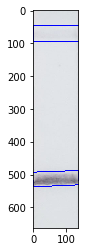

In [9]:
# find the contours in the mask, then sort them from bottom (control band)-to-top (sample band)

cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = contours.sort_contours(cnts, method="bottom-to-top")[0]

# loop over the contours
# there are three possible cases here
# i) if we identify more than 1 band, then we take the first two as being the control and sample band,
# and take those areas as our region of interest for later quantification
# ii) if we only identify 1 band, then the sample band is likely displaying weak intensity and it's location
# must be estimated. We estimate the location by examining a couple of areas where the sample band is likely
# present, and take the area with the highest mean intensity.
# iii) if we identify no bands, we prompt the user to take another picture
roi = []
if len(cnts) > 1:
    for (i, c) in enumerate(cnts):
        # draw the bright spot on the image for the control and sample band 
        x, y, width, height = cv2.boundingRect(c)
        roi.append(image_invert_orig[y:y+height, x:x+width])
        rect = cv2.minAreaRect(c)
        box = cv2.boxPoints(rect)
        # convert all coordinates floating point values to int
        box = np.int0(box)
        # draw a rectangle
        cv2.drawContours(image_orig, [box], 0, (0, 0, 255), thickness=2)

elif len(cnts) == 1:
        # draw the bright spot on the image for the control band
        for (i, c) in enumerate(cnts):
            x, y, width, height = cv2.boundingRect(c)
            roi.append(image_invert_orig[y:y+height, x:x+width])
            rect = cv2.minAreaRect(c)
            box = cv2.boxPoints(rect)
            # convert all coordinates floating point values to int
            box = np.int0(box)
            # draw a rectangle
            cv2.drawContours(image_orig, [box], 0, (0, 0, 255), thickness=2)
            
        # estimate location of sample band
        # we essentially take the control band contours, and drag it along two locations
        # near the top of the strip, where the sample band is likely to be located
        box_ctl_roi = np.array([[0,height], [0,0], [width,0], [width,height]])
        roi_test_1 = image_invert_orig[height:2*height, 0:width]
        roi_test_2 = image_invert_orig[2*height:3*height, 0:width]
        
        if cv2.meanStdDev(roi_test_1)[0] > cv2.meanStdDev(roi_test_2)[0]:
            box_ctl_roi[:,1] = box_ctl_roi[:,1]+height
            roi.append(roi_test_1)
        else:
            box_ctl_roi[:,1] = box_ctl_roi[:,1]+2*height
            roi.append(roi_test_2)
        
        cv2.drawContours(image_orig, [box_ctl_roi], 0, (0, 0, 255), thickness=2)
        
# if no bands are detected, prompt user to retake photo
else :
    print("Error. No bands located. Please retake photo.")

# display image with contours overlayed 
implt(image_orig) 

# # show the output image
# cv2.imshow("Image", image_invert_jpg)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [11]:
# output ratio of sample to control band

ratio = float(cv2.meanStdDev(roi[1])[0] / cv2.meanStdDev(roi[0])[0])

thresh = 0.50 

if ratio >= thresh:
    print("The sample band ratio [" + str(ratio) + "] suggests a " + target_to_detect +"-POSITIVE test.")
else:
    print("The sample band ratio [" + str(ratio) + "] suggests a " + target_to_detect +"-NEGATIVE test.")


The sample band ratio [0.4122666172029423] suggests a CMV-NEGATIVE test.
